In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
import multiprocessing as mp
import time
import glob
import re
import random
from sklearn.model_selection import train_test_split
import torch

sys.path.insert(0, '/Data/user/panhailin/git_lab/npspy')
import npspy as nps

# 全局配置

In [2]:
torch.set_num_threads(10)

all_peps = [['1K', '1R'], ['1D', '1E'], ['1F', '1W', '1Y', '1I', '1L', '1M', '1V', '1H', '1Q', '1A', '1G', '1S', '1C', '1P', '1T', '1N']]

y_code_dict = nps.ml.set_y_codes_for_classes(all_peps)
y_code_dict
y_to_label_dict = {0: 'positive', 1: 'negative', 2: 'neutral'}
y_code_dict, y_to_label_dict

({'1K': 0,
  '1R': 0,
  '1D': 1,
  '1E': 1,
  '1F': 2,
  '1W': 2,
  '1Y': 2,
  '1I': 2,
  '1L': 2,
  '1M': 2,
  '1V': 2,
  '1H': 2,
  '1Q': 2,
  '1A': 2,
  '1G': 2,
  '1S': 2,
  '1C': 2,
  '1P': 2,
  '1T': 2,
  '1N': 2},
 {0: 'positive', 1: 'negative', 2: 'neutral'})

In [3]:
tmp = []
for i in all_peps:
    tmp.extend(i)
all_peps = tmp

In [4]:
train_objs = [f"../../../03.results/classification_on_clean_data/GSXGS/{pep}/{pep}_valid80_clean_obj.pkl" for pep in all_peps]
test_objs = [f"../../../03.results/classification_on_clean_data/GSXGS/{pep}/{pep}_valid20_clean_obj.pkl" for pep in all_peps]
labels = all_peps

In [5]:
def stratified_sample(df, column_name, sample_size=15000, random_state=42):
    """
    对DataFrame按指定列类别分层随机抽样
    
    参数:
        df: 输入DataFrame
        column_name: 分层依据的列名
        sample_size: 每类抽取样本数(默认15000)
        random_state: 随机种子
    
    返回:
        抽样后的新DataFrame
    """
    re_df = df.groupby(column_name, group_keys=True).apply(
        lambda x: x.sample(min(len(x), sample_size), 
                          random_state=random_state),
        include_groups=False,
    )
    re_df[re_df.index.names[0]] =  [i[0] for i in re_df.index]
    re_df.index = [i[1] for i in re_df.index]
    return re_df

# 读取pkl文件，生成readid，X，y组成的df

In [6]:
train_df = nps.ml.get_X_y_from_objs(objs=train_objs, labels=labels, y_code_dict=y_code_dict, down_sample_to=1000, att='signal')
train_df = stratified_sample(train_df, 'y', sample_size=25000, random_state=42)
train_df, valid_df = train_test_split(train_df, test_size=1/8, random_state=42, stratify=train_df['y'])
test_df = nps.ml.get_X_y_from_objs(objs=test_objs, labels=labels, y_code_dict=y_code_dict, down_sample_to=1000, att='signal')
test_df = stratified_sample(test_df, 'y', sample_size=6000, random_state=42)

# 通过data_df构建dataloader

In [7]:
batch_size = 64
train_dl = nps.ml.construct_dataloader_from_data_df(train_df, batch_size=batch_size, augment=False)
valid_dl = nps.ml.construct_dataloader_from_data_df(valid_df, batch_size=batch_size)
test_dl = nps.ml.construct_dataloader_from_data_df(test_df, batch_size=batch_size, shuffle=False)

# 初步训练

In [8]:
nps.ml.seed_everything(42)
clf = nps.ml.Trainer(lr=0.005, num_classes=len(y_to_label_dict), epochs=200, device='cuda', lr_scheduler_patience=3, label_smoothing=0.1, model_name='CNN1DL1000')
clf.fit(train_dl, valid_dl, early_stopping_patience=30, name='clean_data_large_group')

Model CNN1DL1000 has total parameter number: 6.21 M
Epoch   0 / 200 train_loss: 0.6851 train_acc: 0.7914 val_loss: 0.7524 val_acc: 0.7495 lr: 0.005
Epoch   1 / 200 train_loss: 0.5368 train_acc: 0.8674 val_loss: 0.5591 val_acc: 0.8465 lr: 0.005
Epoch   2 / 200 train_loss: 0.4976 train_acc: 0.8904 val_loss: 0.7793 val_acc: 0.6826 lr: 0.005
Epoch   3 / 200 train_loss: 0.4796 train_acc: 0.9004 val_loss: 0.6300 val_acc: 0.8097 lr: 0.005
Epoch   4 / 200 train_loss: 0.4640 train_acc: 0.9082 val_loss: 0.9814 val_acc: 0.6038 lr: 0.005
Epoch   5 / 200 train_loss: 0.4526 train_acc: 0.9146 val_loss: 0.5869 val_acc: 0.8353 lr: 0.0025
Epoch   6 / 200 train_loss: 0.4261 train_acc: 0.9286 val_loss: 0.4411 val_acc: 0.9180 lr: 0.0025
Epoch   7 / 200 train_loss: 0.4173 train_acc: 0.9333 val_loss: 0.4457 val_acc: 0.9131 lr: 0.0025
Epoch   8 / 200 train_loss: 0.4089 train_acc: 0.9379 val_loss: 0.4353 val_acc: 0.9207 lr: 0.0025
Epoch   9 / 200 train_loss: 0.4023 train_acc: 0.9418 val_loss: 0.4314 val_acc: 0

In [10]:
nps.ml.seed_everything(42)
clf = nps.ml.Trainer(lr=0.005, num_classes=len(y_to_label_dict), epochs=200, device='cuda', lr_scheduler_patience=3, label_smoothing=0.1, model_name='CNN1DL1000')

pred_df = clf.predict(test_dl, name='clean_data_large_group', y_to_label_dict=y_to_label_dict)
test_all_reads_s = pred_df['true'].value_counts()
cm_df = nps.ml.get_cm(pred_df, label_order=y_to_label_dict.values())
cm_df.to_csv("../../../04.tables/classification/GSXGS/large_group_clean_cm.csv")
print(cm_df)
print(np.sum(np.diag(cm_df))/len(pred_df))
pred_proba_df = clf.predict_proba(test_dl, name='clean_data_large_group')
pred_proba_df.to_csv(f"../../../03.results/classification_on_clean_data/GSXGS/clean/clean_data_large_group_pred_proba.csv")

Model CNN1DL1000 has total parameter number: 6.21 M
 test_acc: 0.9331
pred      positive  negative  neutral
true                                 
positive      5702        24      274
negative        44      5642      314
neutral        223       326     5451
0.9330555555555555
 test_acc: 0.9331


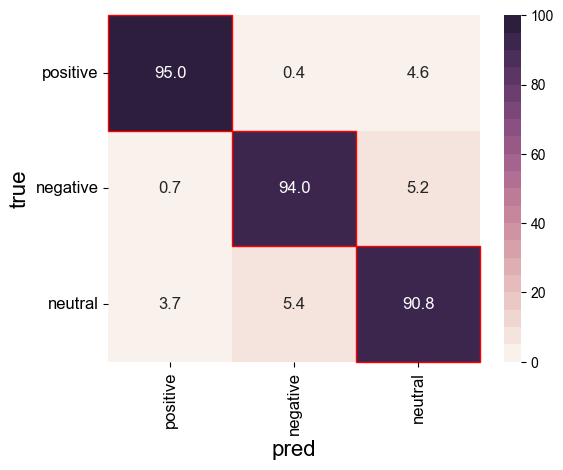

In [11]:
plt.rcParams['axes.labelsize'] = 16
nps.ml.plot_cm(cm_df, figsize=(6,4.5), nor_to_percent_for_each_pred=True, annot_size=12.0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("../../../05.figures/classification/GSXGS/large_group_clean_cm.pdf")